# Проект 3. Дашборд конверсий

In [5]:
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates

In [7]:
from dotenv import load_dotenv

load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')


In [9]:
api_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
data_visits = api_visits.json()


In [11]:
api_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
data_regs = api_regs.json()


**Создаем датафреймы, меняем формат временной метки и создаем дополнительный столбец, содержащий только дату**

In [13]:
visits = pd.DataFrame(api_visits.json())

In [15]:
regs = pd.DataFrame(api_regs.json())

In [17]:
visits['datetime'] = pd.to_datetime(visits['datetime'])
visits['date'] = pd.to_datetime(visits['datetime']).dt.date

In [19]:
regs['datetime'] = pd.to_datetime(regs['datetime'])
regs['date'] = pd.to_datetime(regs['datetime']).dt.date

**Чистим датафрейм с посещениями от ботов**

In [22]:
visits = visits[~visits['user_agent'].str.contains('bot')]

**Оставляем только последние визиты по Visit_id**

In [25]:
last_visits = visits.groupby(['visit_id'], as_index=False).datetime.agg('max')

In [27]:
last_visits = last_visits.merge(visits, left_on=['visit_id','datetime'], right_on=['visit_id','datetime'],how='left')

In [29]:
last_visits

,visit_id,datetime,platform,user_agent,date
0,000012d3-f8c7-4257-8999-ad622b703492,2023-06-06 20:32:30,android,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2023-06-06
1,0000164b-36eb-409a-8ab4-4acc25e5f3de,2023-08-16 11:36:01,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-08-16
2,0000190e-e494-4fe1-876f-0dc2b4e1be1c,2023-07-02 18:49:04,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-07-02
3,000063a2-6a6c-466a-b7e5-781568668a6b,2023-08-29 20:14:40,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-08-29
4,0000b829-7f90-4a38-b831-9b314ecfd8b5,2023-07-02 07:20:46,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-07-02
...,...,...,...,...,...
138698,fffdeef9-4267-4cbc-83aa-904b8f84b41e,2023-05-28 11:58:30,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-05-28
138699,fffe1fbd-79c0-43df-bea4-8fdcf90aef4b,2023-04-12 19:31:29,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-04-12
138700,fffec696-dd2a-4e8f-8199-6ebce7fe9740,2023-05-28 11:43:23,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-05-28
138701,ffff4661-ee3d-4272-87d5-bf70fb0818e4,2023-06-17 06:37:18,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-06-17


**Группируем датафреймы по дате и платформе**

In [32]:
visits_gr = last_visits.groupby(['date', 'platform'],as_index=False)['visit_id']\
            .nunique().rename(columns={'visit_id':'visits'})

In [34]:
regs_gr = regs.groupby(['date', 'platform'],as_index=False)['user_id']\
            .nunique().rename(columns={'user_id':'registrations'})

In [36]:
visits_gr['date'] = pd.to_datetime(visits_gr['date'])
regs_gr['date'] = pd.to_datetime(regs_gr['date'])

**Проверяем сгруппированные датафреймы: оба содержат одинаковое количество строк**

In [39]:
visits_gr.info()
regs_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      552 non-null    datetime64[ns]
 1   platform  552 non-null    object        
 2   visits    552 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           552 non-null    datetime64[ns]
 1   platform       552 non-null    object        
 2   registrations  552 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.1+ KB


**Создаем объединенный датафрейм по дате и платформе и находим конверсию по дате в %**

In [42]:
merged_df = pd.merge(visits_gr, regs_gr,
                     how='outer',
                     left_on=['date', 'platform'],
                     right_on=['date', 'platform']
                    )

In [44]:
merged_df['conversion']=round(merged_df['registrations']*100/merged_df['visits'],2)

In [46]:
merged_df

,date,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.33
1,2023-03-01,ios,22,18,81.82
2,2023-03-01,web,279,8,2.87
3,2023-03-02,android,67,59,88.06
4,2023-03-02,ios,31,24,77.42
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.61
548,2023-08-30,web,1227,34,2.77
549,2023-08-31,android,57,42,73.68
550,2023-08-31,ios,50,36,72.00


In [48]:
merged_df.to_json('./conversion.json')

**Добавляем данные по рекламным кампаниям**

In [50]:
ads = pd.read_csv('ads.csv')

In [69]:
ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265


In [56]:
# Меняем формат временной метки на дату
ads['date'] = pd.to_datetime(pd.to_datetime(ads['date']).dt.date)

In [61]:
result = merged_df.groupby(['date'], as_index=False)\
            .agg({'visits':'sum', 'registrations':'sum'})\
            .merge(ads, how='left', left_on='date', right_on='date')

In [67]:
result.to_json('./ads.json')

In [65]:
result

,date,visits,registrations,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,376,87,google,cpc,advanced_algorithms_series,212.0
1,2023-03-02,613,106,google,cpc,advanced_algorithms_series,252.0
2,2023-03-03,683,107,google,cpc,advanced_algorithms_series,202.0
3,2023-03-04,647,159,google,cpc,advanced_algorithms_series,223.0
4,2023-03-05,707,115,google,cpc,advanced_algorithms_series,265.0
...,...,...,...,...,...,...,...
179,2023-08-27,795,88,vk,social,intro_to_python_course,222.0
180,2023-08-28,635,83,vk,social,intro_to_python_course,223.0
181,2023-08-29,1268,143,vk,social,intro_to_python_course,190.0
182,2023-08-30,1328,101,vk,social,intro_to_python_course,109.0


## Визуальный анализ данных

**Распределение количества визитов по дням**

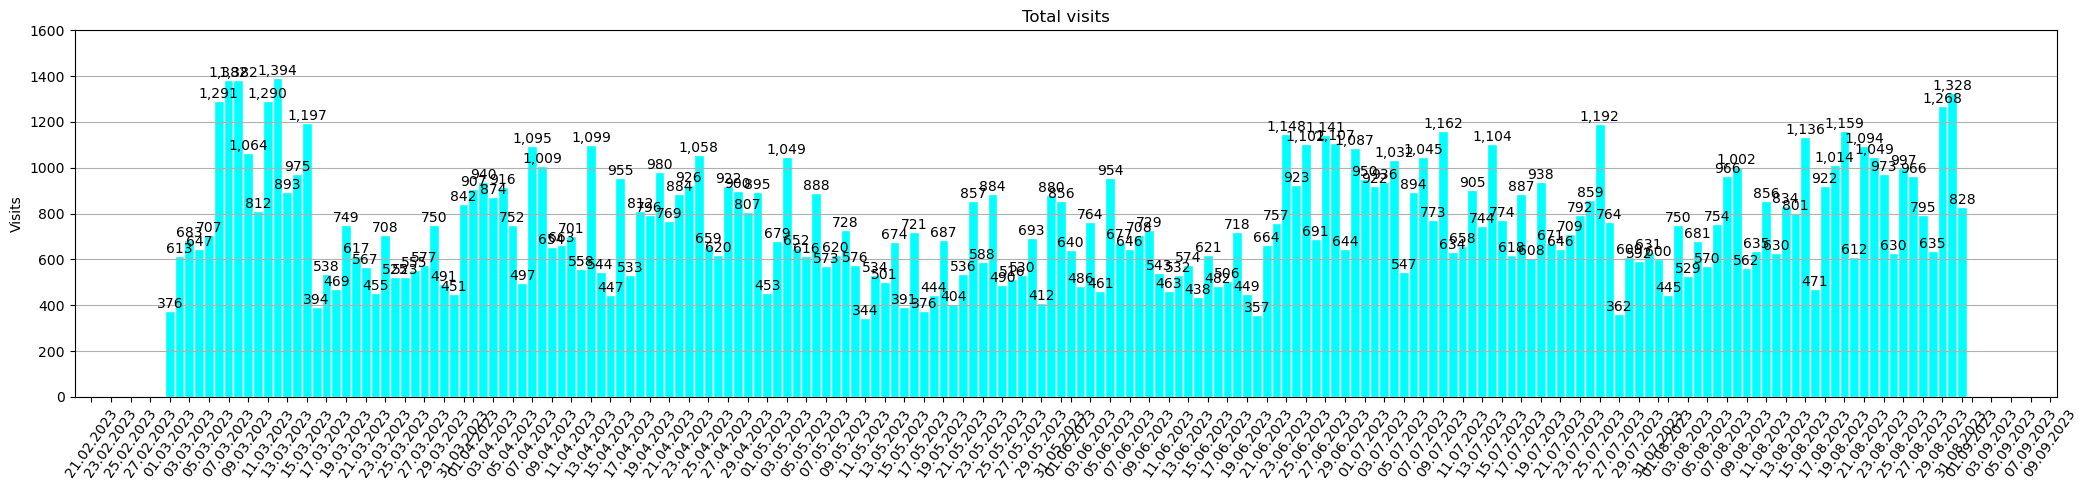

In [79]:
df = merged_df.groupby(['date'],as_index=False).visits.sum()
fig, ax = plt.subplots()
fig.set_size_inches(21, 5)
# Повернем метки рисок на 55 градусов
ax.tick_params(axis="x", labelrotation=55)
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
#Изменим локатор, используемый по умолчанию
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)
# Отобразим данные
bar_container = ax.bar(df['date'], df['visits'],
       width=1,
       color='cyan',
      edgecolor='white')
# Отмасштабируем график, чтобы в окно уместились повернутые надписи
ax.set(ylabel='Visits', title='Total visits', ylim=(0, 1600))
plt.tight_layout()
# Добавляем надписи для столбцов
ax.bar_label(bar_container, fmt='{:,.0f}')
ax.grid(axis='y')
plt.show()

**Итоговые визиты с разбивкой по платформам**


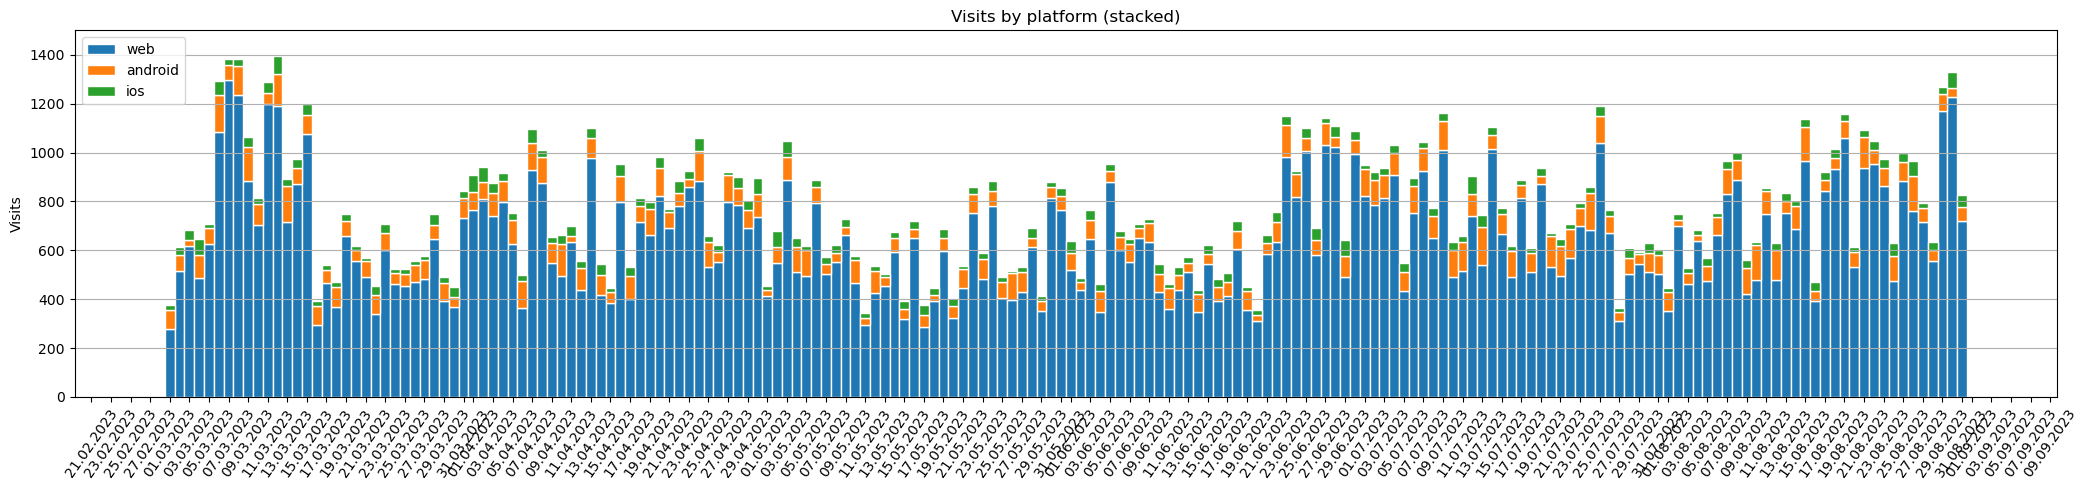

In [75]:
# Преобразуем данные в сводную таблицу, в которой названия платформ будут расположены в колонках, а даты — в строках.
df = merged_df \
    .groupby(['date', 'platform'], as_index=False) \
    .agg({'visits': 'sum'}) \
    .pivot(index='date', columns='platform', values='visits') \
    .fillna(0).astype('int') \
    .sort_index(ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(21, 5)

# Повернем метки рисок на 55 градусов
ax.tick_params(axis="x", labelrotation=55)
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
#Изменим локатор, используемый по умолчанию
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)

# Строим барплот с накоплением
ax.bar(df.index, df["web"], label = "web", width = 1,
      edgecolor='white') 
ax.bar(df.index, df["android"], label = "android", bottom = df.web, width = 1,
      edgecolor='white')
ax.bar(df.index, df["ios"], bottom = df.android + df.web, label = "ios", width = 1,
      edgecolor='white') 
# Отмасштабируем график, чтобы в окно уместились повернутые надписи
ax.set(ylabel='Visits', title='Visits by platform (stacked)', ylim=(0, 1500))

ax.legend(labels = ["web", "android", "ios"])
plt.tight_layout()
ax.grid(axis='y')

plt.show()


**Распределение количества регистраций по дням**

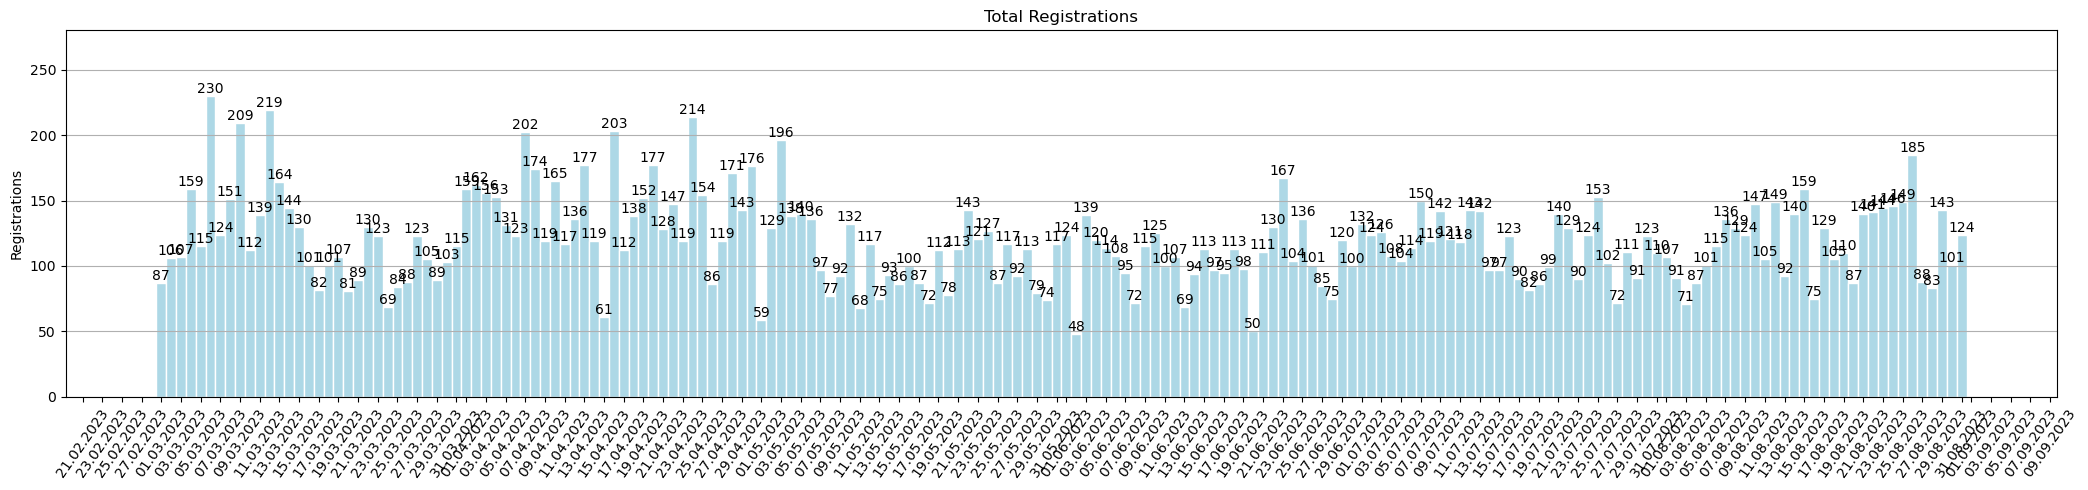

In [81]:
df = merged_df.groupby(['date'],as_index=False).registrations.sum()
fig, ax = plt.subplots()
fig.set_size_inches(21, 5)
# Повернем метки рисок на 55 градусов
ax.tick_params(axis="x", labelrotation=55)
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
#Изменим локатор, используемый по умолчанию
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)
# Отобразим данные
bar_container = ax.bar(df['date'], df['registrations'],
       width=1,
       color='lightblue',
      edgecolor='white')
# Отмасштабируем график, чтобы в окно уместились повернутые надписи
ax.set(ylabel='Registrations', title='Total Registrations', ylim=(0, 280))
plt.tight_layout()
# Добавляем надписи для столбцов
ax.bar_label(bar_container, fmt='{:,.0f}')
ax.grid(axis='y')
plt.show()


**Итоговые регистрации с разбивкой по платформам**

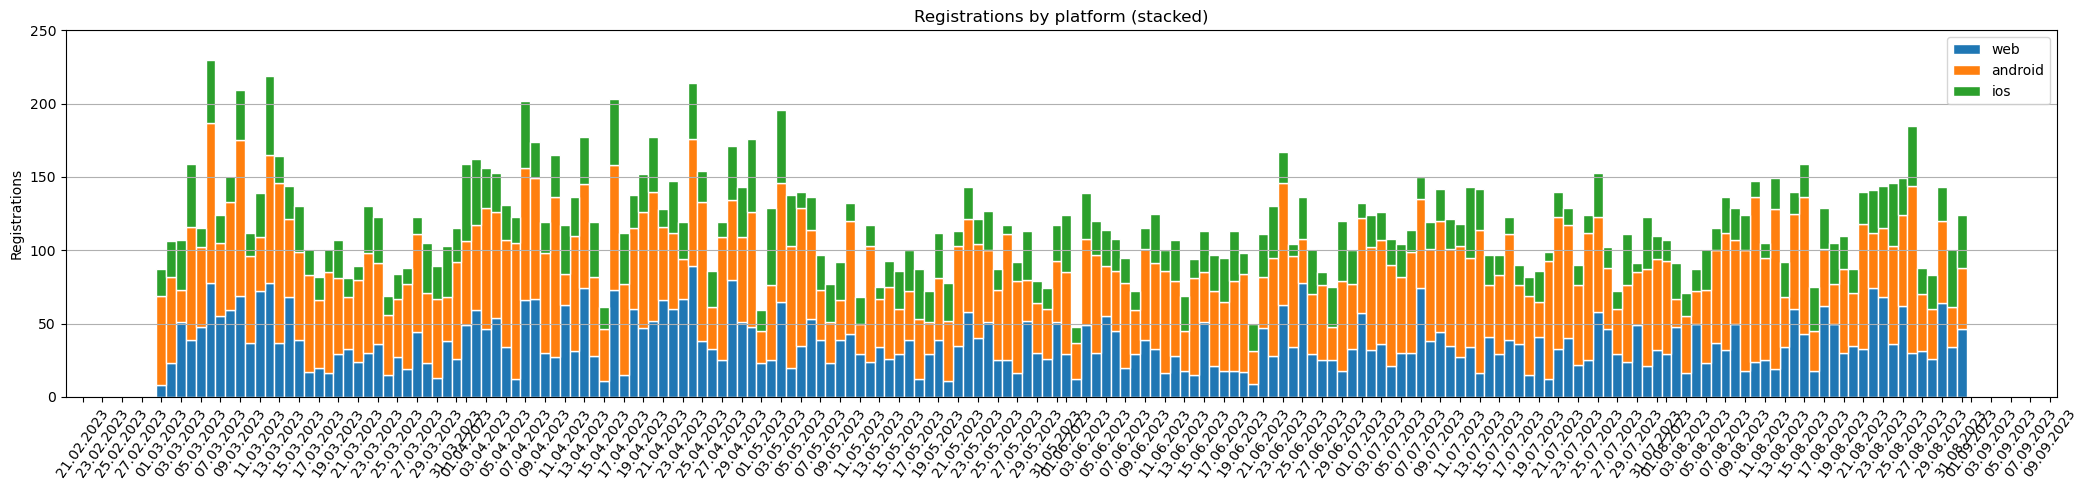

In [83]:
# Преобразуем данные в сводную таблицу, в которой названия платформ будут расположены в колонках, а даты — в строках.
df = merged_df \
    .groupby(['date', 'platform'], as_index=False) \
    .agg({'registrations': 'sum'}) \
    .rename(columns={'registrations': 'registrations_count'}) \
    .pivot(index='date', columns='platform', values='registrations_count') \
    .fillna(0).astype('int') \
    .sort_index(ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(21, 5)

# Повернем метки рисок на 55 градусов
ax.tick_params(axis="x", labelrotation=55)
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
#Изменим локатор, используемый по умолчанию
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)


ax.bar(df.index, df["web"], label = "web", width = 1,
      edgecolor='white') 
ax.bar(df.index, df["android"], label = "android", bottom = df.web, width = 1,
      edgecolor='white')
ax.bar(df.index, df["ios"], bottom = df.android + df.web, label = "ios", width = 1,
      edgecolor='white') 
# Отмасштабируем график, чтобы в окно уместились повернутые надписи
ax.set(ylabel='Registrations', title='Registrations by platform (stacked)', ylim=(0, 250))

ax.legend(labels = ["web", "android", "ios"])

plt.tight_layout()
ax.grid(axis='y')

plt.show()

**Конверсии по каждой платформе**

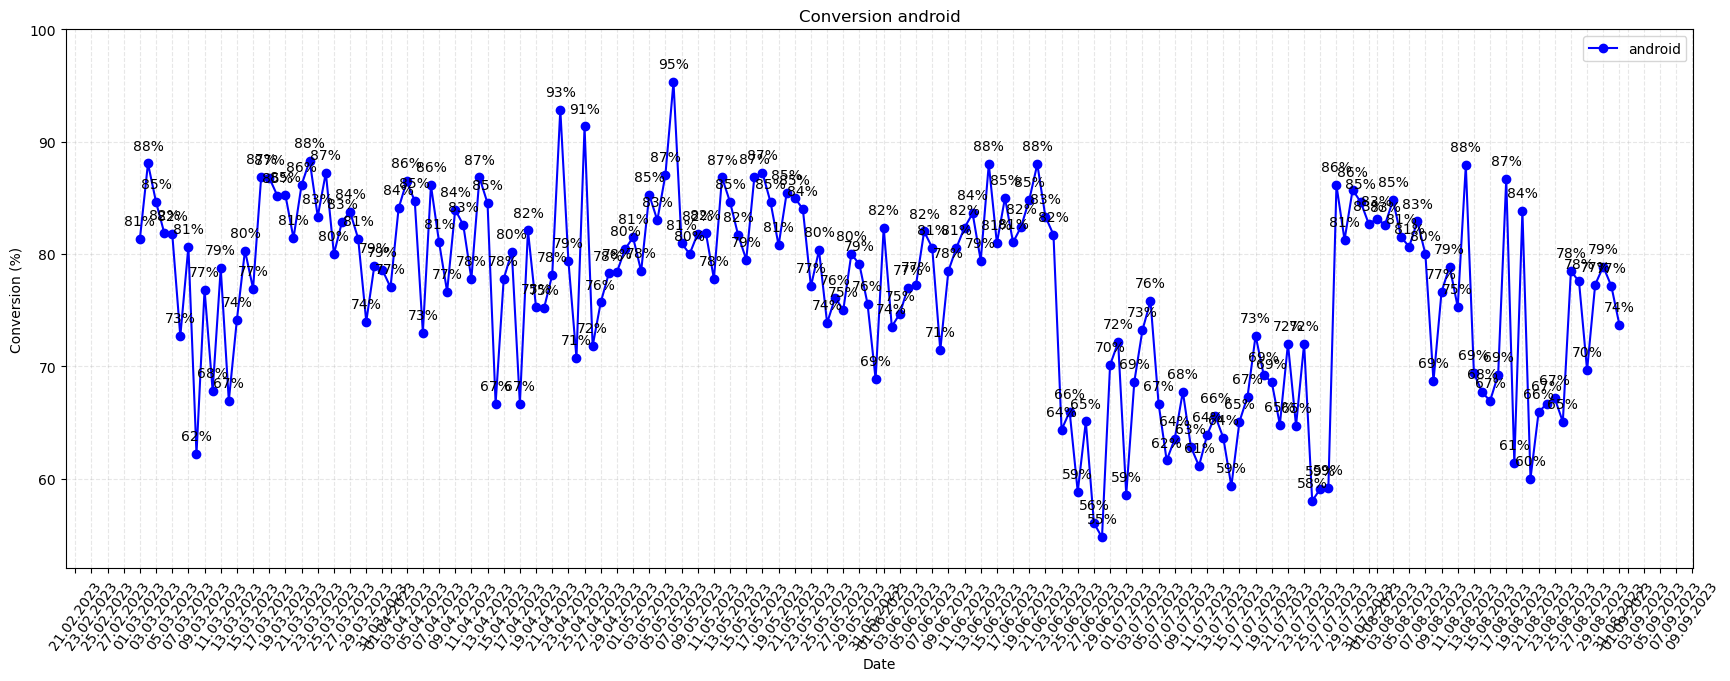

In [85]:
# Конверсия по android
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
values_and = merged_df[merged_df['platform'] == 'android']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']
ax.tick_params(axis="x", labelrotation=55)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)

ax.plot(labels,
        values_and,
        # 'bo-' means blue color, round points, solid lines
        'bo-')
ax.grid(True, linestyle='--', alpha=0.3)

# zip joins x and y coordinates in pairs
for l,v in zip(labels,values_and):
    value = "{:.0f}".format(v)+'%'
    plt.annotate(value, # this is the text
                 (l,v), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion android', ylim=(52, 100))
ax.legend(["android"])
plt.show()


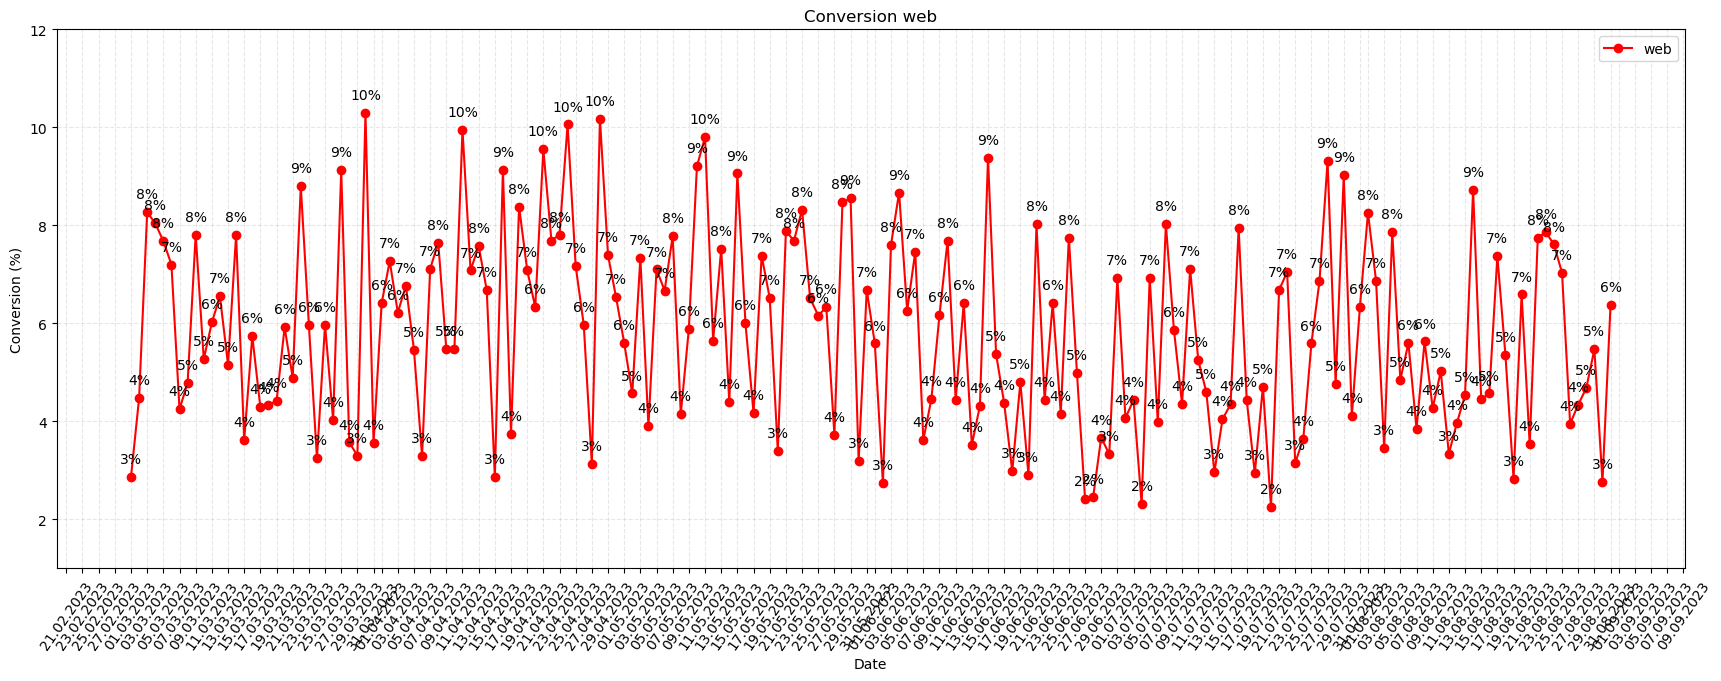

In [87]:
# Конверсия по web
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
values_web = merged_df[merged_df['platform'] == 'web']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']
ax.tick_params(axis="x", labelrotation=55)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)

ax.plot(labels,
        values_web,
        'ro-')
ax.grid(True, linestyle='--', alpha=0.3)

for l,v in zip(labels,values_web):
    value = "{:.0f}".format(v)+'%'
    plt.annotate(value, 
                 (l,v), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center') 

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion web', ylim=(1, 12))
ax.legend(["web"])
plt.show()


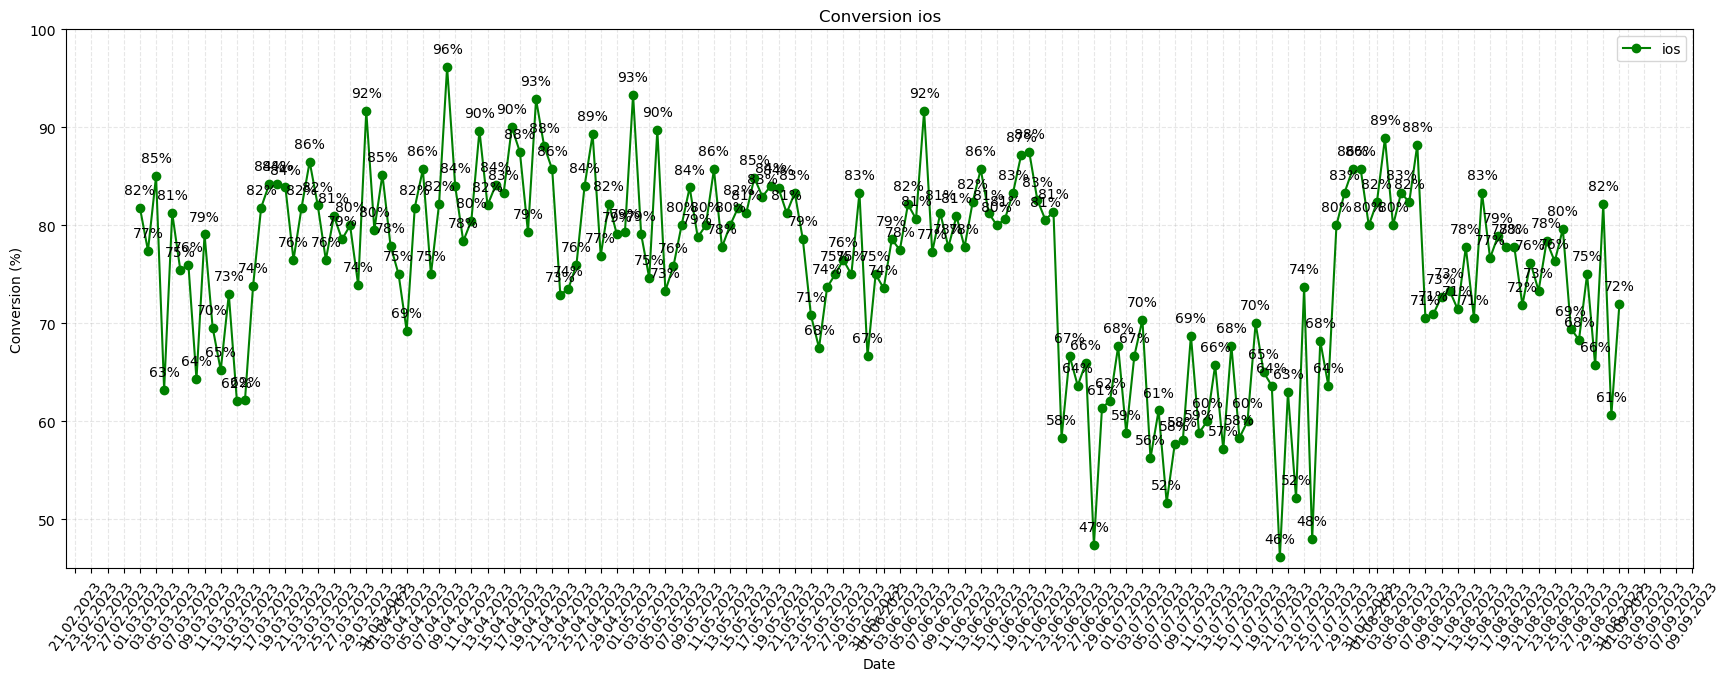

In [89]:
# Конверсия по ios
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
values_ios = merged_df[merged_df['platform'] == 'ios']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']
ax.tick_params(axis="x", labelrotation=55)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)

ax.plot(labels,
        values_ios,
        'go-')
ax.grid(True, linestyle='--', alpha=0.3)

for l,v in zip(labels,values_ios):
    value = "{:.0f}".format(v)+'%'
    plt.annotate(value, 
                 (l,v), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center') 

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion ios', ylim=(45, 100))
ax.legend(["ios"])
plt.show()


Итоговые конверсии

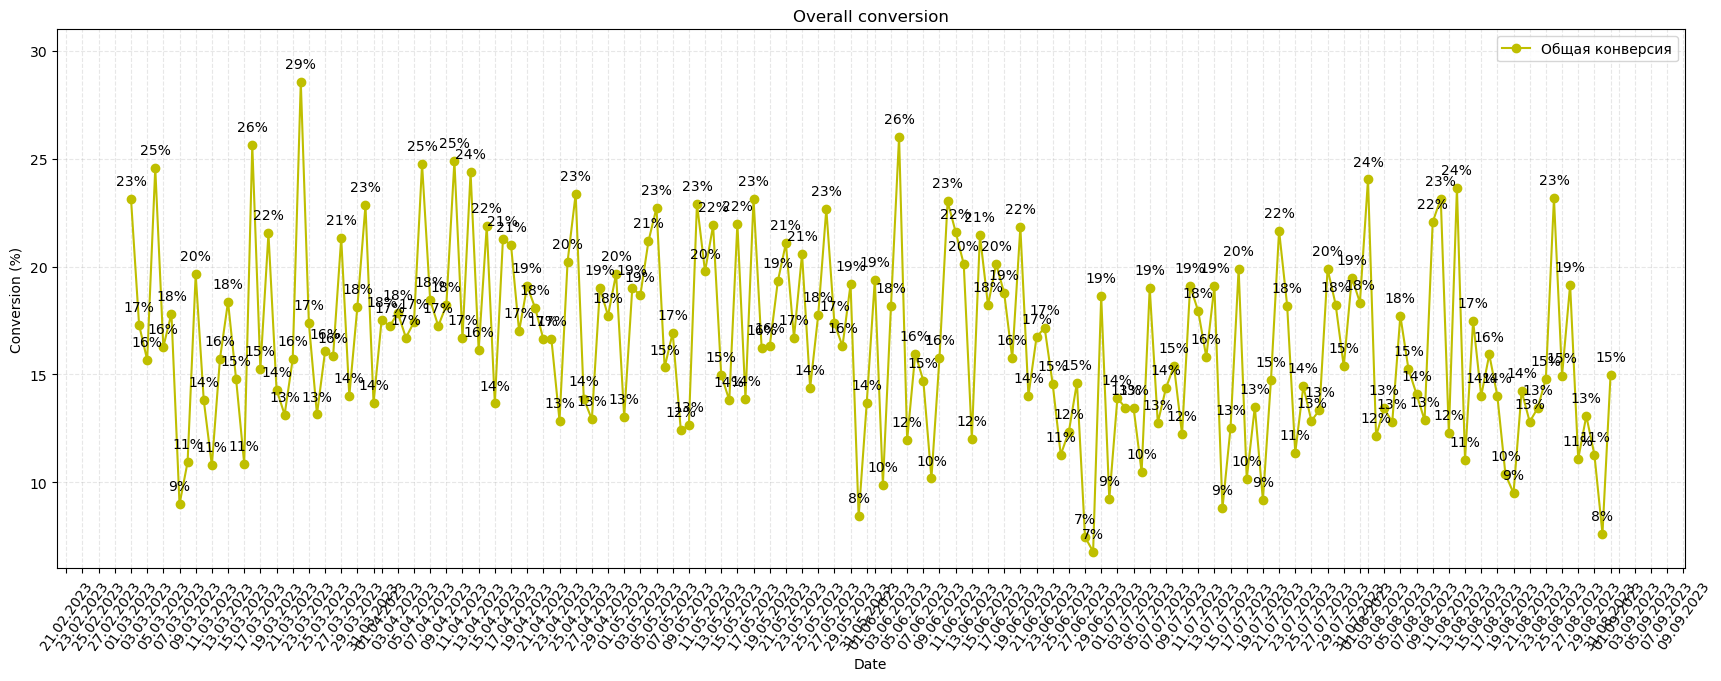

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
data = result.assign(conversion=lambda x: round(x.registrations*100/x.visits,2))
values = data['conversion']
labels = data['date']
ax.tick_params(axis="x", labelrotation=55)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)

ax.plot(labels,
        values,
        'yo-')
ax.grid(True, linestyle='--', alpha=0.3)

for l,v in zip(labels,values):
    value = "{:.0f}".format(v)+'%'
    plt.annotate(value, 
                 (l,v), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center') 

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Overall conversion', ylim=(6, 31))
ax.legend(["Общая конверсия"])
plt.show()

Стоимости реклам

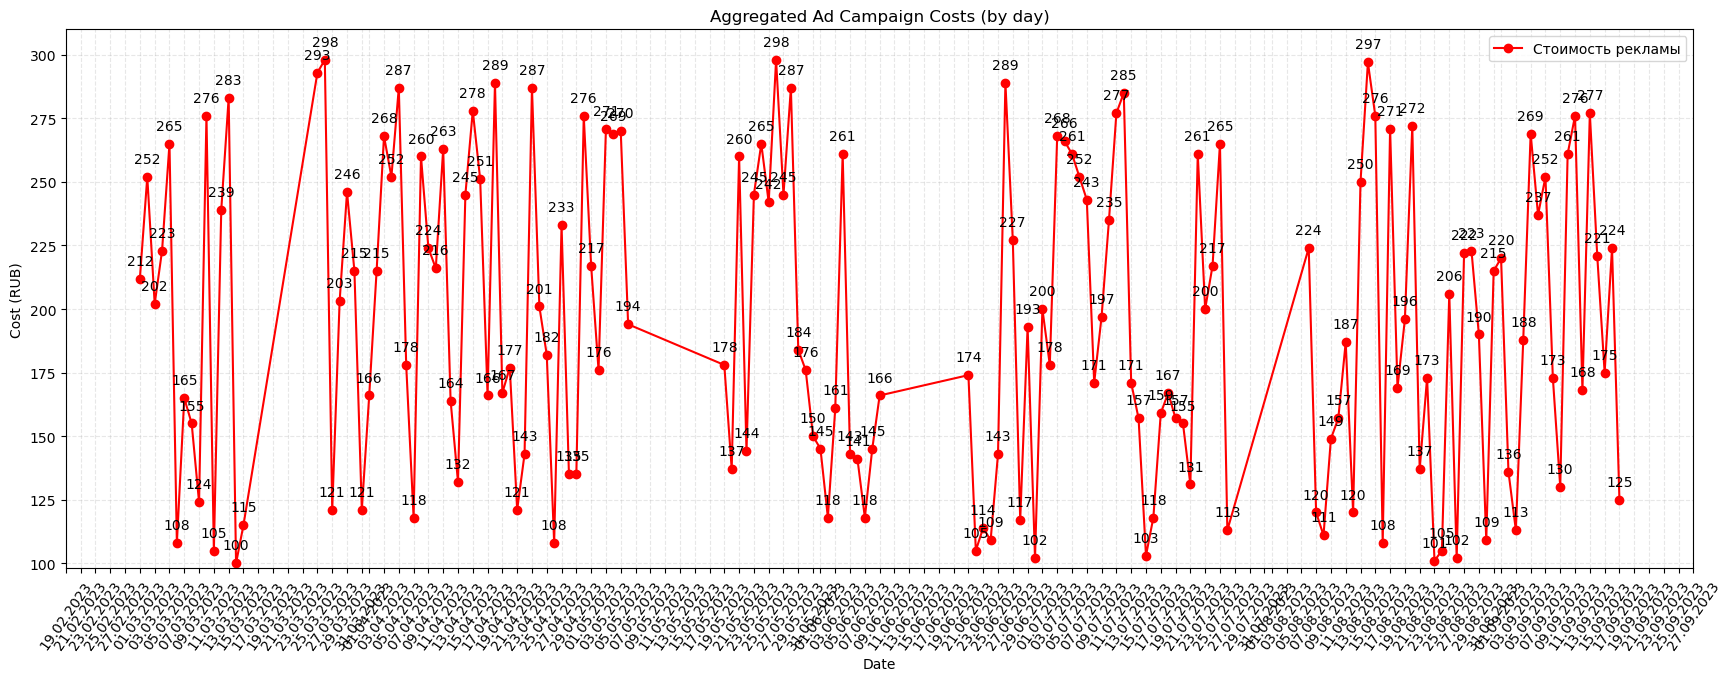

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
values = ads['cost']
labels = ads['date']
ax.tick_params(axis="x", labelrotation=55)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m.%Y"))
locator = matplotlib.dates.AutoDateLocator(minticks=result.date.nunique(), maxticks=result.date.nunique()+1)
ax.xaxis.set_major_locator(locator)

ax.plot(labels,
        values,
        'ro-')
ax.grid(True, linestyle='--', alpha=0.3)

for l,v in zip(labels,values):
    value = "{:.0f}".format(v)
    plt.annotate(value, 
                 (l,v), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center') 

ax.set(ylabel='Cost (RUB)', xlabel='Date', title='Aggregated Ad Campaign Costs (by day)', ylim=(98, 310))
ax.legend(["Стоимость рекламы"])
plt.show()

Визиты и регистрации с выделением рекламных кампаний

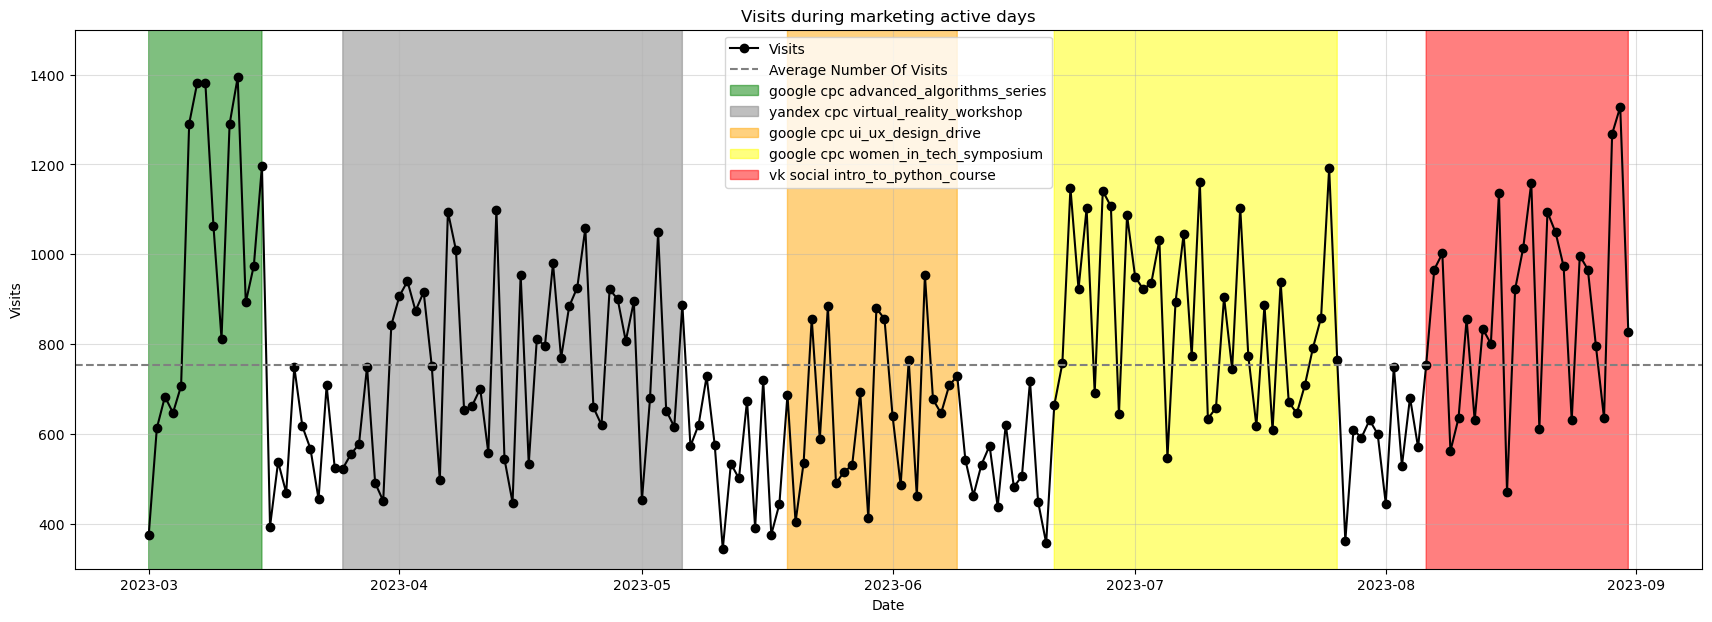

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])
# Список всех рекламных кампаний
ads_names = list(data['ad'].unique())
# Датафрейм с датами начала и окончания рекламных кампаний
ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

values = data['visits']
labels = data['date']

ax.plot(labels, values, 'ko-')
ax.grid(True, linestyle='-', alpha=0.4)
ax.set(ylabel='Visits', xlabel='Date', title='Visits during marketing active days', ylim=(300,1500))

# Рисуем линию среднего
plt.axhline(y=values.mean(), color='grey', linestyle='--')

# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.legend(['Visits',
           'Average Number Of Visits', 
           'google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.show()

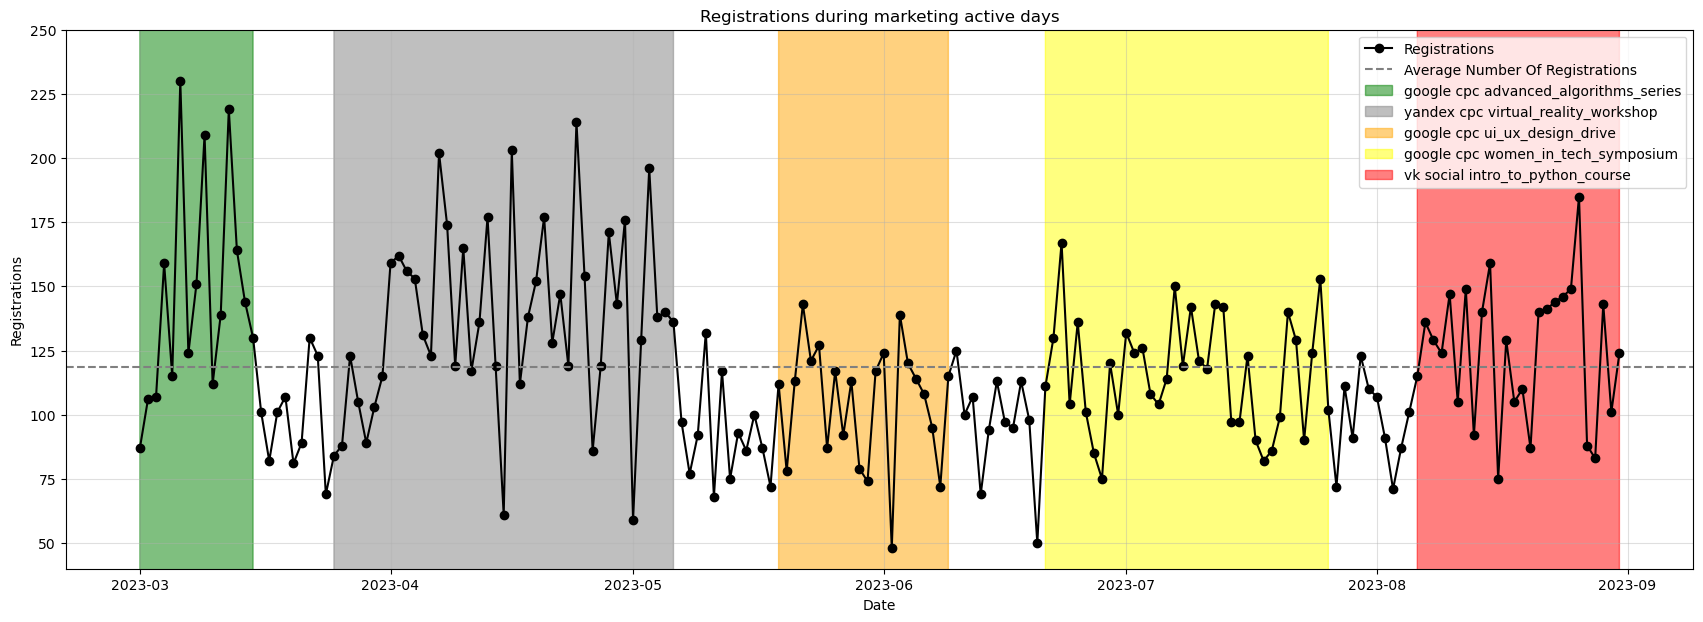

In [99]:
fig, ax = plt.subplots()
fig.set_size_inches(21, 7)
data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])

ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

values = data['registrations']
labels = data['date']

ax.plot(labels, values, 'ko-')
ax.grid(True, linestyle='-', alpha=0.4)

ax.set(ylabel='Registrations', xlabel='Date', title='Registrations during marketing active days', ylim=(40,250))

# Рисуем линию среднего
plt.axhline(y=values.mean(), color='grey', linestyle='--')

# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.legend(['Registrations',
           'Average Number Of Registrations', 
           'google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.show()